## LCC calculation tests (for whole track)

Notebook to test the LCC calculations for the whole track, i.e., high and low rail.

Version 0.1 (2025-05-07): initial version with simple exploration of all possible maintenance strategies.


## Setting parameters

In [1]:
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

In [2]:
# Define the high and low rail profile
profile_high_rail = "MB5"  # MB5 (default) or MB6
profile_low_rail = "MB5"  # MB5 (default) or MB6

# Define the axle load (in tonnes)
load_high = 32.5

# The actual path to your Excel file
file_path = '../data/raw/raw_data_structured_with_load.csv'

## Reading input data

In [3]:
# Ensure the preprocessings module is accessible
import sys
sys.path.append('../')  # Adjust the path to the root directory containing 'preprocessings'

# Import the function to read the input data
from preprocessings.read_input_data import read_input_data

# Call the function to read the data
data_df = read_input_data(file_path)

## LCC calculation

In [4]:
import numpy as np  # type: ignore
from scipy.interpolate import PchipInterpolator  # type: ignore
from rail_analysis.LCC_track import get_annuity_track


# Example usage of the function
grinding_freq_low = 6  # months
grinding_freq_high = 6  # months
gauge_freq = 40  # months

annuity, lifetime, history = get_annuity_track(
    data_df,
    grinding_freq_low,
    grinding_freq_high,
    gauge_freq,
    track_results=True
)

print(f"Annuity: {annuity:.2f} €/km/year")
print(f"Lifetime: {lifetime:.2f} years")

Annuity: 1325.45 €/km/year
Lifetime: 15.00 years


## Plots

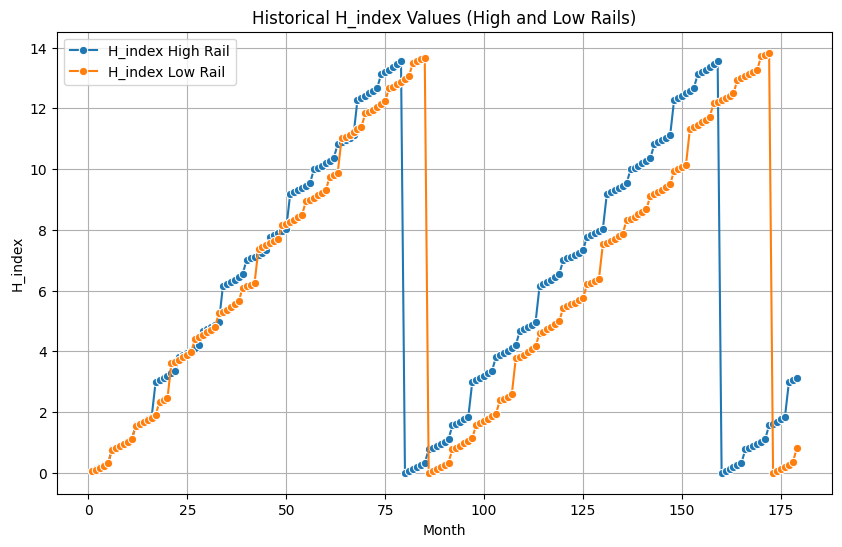

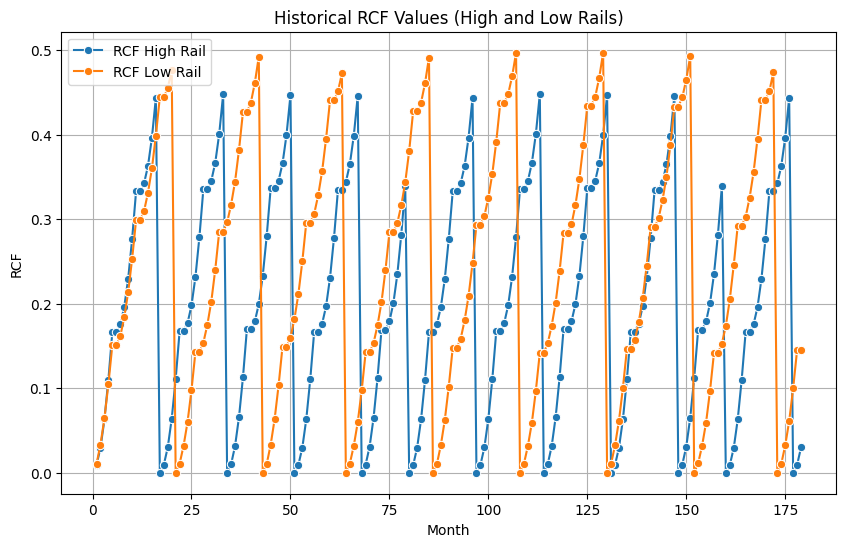

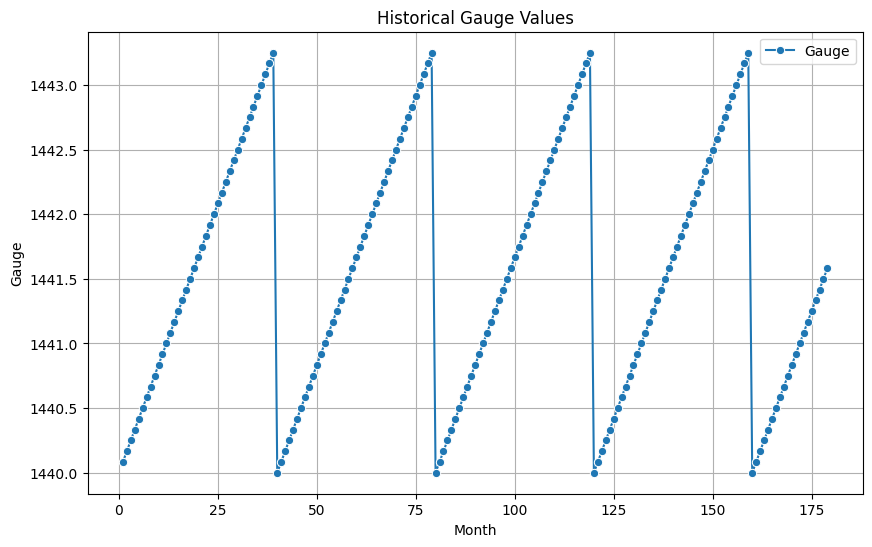

Track lifetime in months: 179
Track lifetime in years: 14.92


In [5]:
from rail_analysis.LCC_track import plot_historical_data

# Example call
plot_historical_data(history)